In [1]:
%matplotlib nbagg
%load_ext autoreload
%autoreload 2

In [2]:

import sys
sys.path.insert(1, '/Users/bangun/pyptychostem-master')
from STEM4D import Data4D, SSB, WDD
from libertem.common import Shape 
from scipy.ndimage import center_of_mass  
from live_wdd.live_wdd import prepare_livewdd
from live_wdd.wdd_udf import WDDUDF
from live_wdd.dim_reduct import get_sampled_basis, compress, decompress
import time
import numpy as np

cannot load pixstem package...
4D plot not possible


In [3]:
import tikzplotlib

In [4]:
import matplotlib.pyplot as plt

In [5]:
from libertem.udf.sum import SumUDF

In [6]:
from libertem.api import Context

In [7]:
#!/usr/bin/env python3

from STEM4D import Data4D, SSB, WDD
import numpy as np
import multiprocessing
#import hyperspy.api as hs
#%matplotlib tk
#import hyperspy.extensions
import sys
try:
    import pixstem.api as ps
except:
    print('cannot load pixstem package...')
    print('iCOM not possible')


if len(sys.argv)==1:
    parfile = sys.argv[1]
else:
 
    #parfile ='/Users/bangun/pyptychostem/parameters_moellenstedt.txt'
    parfile ='/Users/bangun/pyptychostem/parameters.txt'
    
#params = np.genfromtxt(parfile,delimiter='\t',dtype=str)
    
par_dictionary = {}

file = open(parfile)

for line in file:
    if line.startswith('##'):
        continue
    split_line = line.rstrip().split('\t')
    print(split_line)

    if len(split_line)!=2:
        continue
    key, value = split_line
    par_dictionary[key] = value


cannot load pixstem package...
iCOM not possible
['file', '/Users/bangun/Dataset/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['#file', '/Local/erc-1/bangun/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['method', 'wdd']
['aperture', '0.03']
['stepsize', '0.2']
['voltage', '60.0']
['rotation', '0.0']
['']
['']
['threshold', '0.3']
['workers', '1']
['CBED/BF', '-1']
['dose -1']
['']
['plot_4D', '1']
['plot_4D_reciprocal', '1']
['plot_aperture', '1']
['plot_result', '1']
['plot_trotters', '1']
['plot_power_spectrum', '1']
['']
['save', '1']
['#dose', '50']


In [8]:
method = par_dictionary.get('method','wdd')   
expansion_ratio = float(par_dictionary.get('CBED/BF',-1))
dose = int(par_dictionary.get('dose',-1))   

if  expansion_ratio<1:
    expansion_ratio = None
save = int(par_dictionary.get('save',1))

if method not in ['ssb','wdd','iCOM']:
    print('method not understood')


data_4D = Data4D(parfile)
data_4D.estimate_aperture_size() 

['file', '/Users/bangun/Dataset/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['#file', '/Local/erc-1/bangun/Dataset_PyPtychoSTEM/graphene_simu_reshaped.npy']
['method', 'wdd']
['aperture', '0.03']
['stepsize', '0.2']
['voltage', '60.0']
['rotation', '0.0']
['']
['']
['threshold', '0.3']
['workers', '1']
['CBED/BF', '-1']
['dose -1']
['']
['plot_4D', '1']
['plot_4D_reciprocal', '1']
['plot_aperture', '1']
['plot_result', '1']
['plot_trotters', '1']
['plot_power_spectrum', '1']
['']
['save', '1']
['#dose', '50']
/Users/bangun/pyptychostem/
angle step in the x direction is:  0.003801610778615568


In [9]:
data_4D.truncate_ronchigram(expansion_ratio=expansion_ratio) # crops ronchigram to area of interest


In [10]:

    
data_4D.apply_FT()

wdd = WDD(data_4D)
wdd.run()

In [11]:
# Original pyptychostem reconstruction
wdd_result = wdd.Obj_function
# Double FFT2 to correct orientation
wdd_pyptycho = np.fft.fft2(np.fft.fft2(wdd_result))

In [12]:
dim = data_4D.data_4D.shape

In [13]:
from libertem.api import Context

## Load Dataset using LiberTEM

In [14]:
path = '/Users/bangun/pyptychostem-master/graphene_simu_reshaped.npy'
 
# Create context
ctx = Context()
  
ds=ctx.load("npy", path=path, nav_shape=(dim[0], dim[1]), sig_shape=(dim[2], dim[3]))  
ds.set_num_cores(4*18)


In [15]:
sum_udf = ctx.run_udf(dataset=ds, udf=SumUDF(), progress=False)['intensity'].data/np.prod(dim[0:2])

In [16]:
np.allclose(np.sum(data_4D.data_4D, (0,1))/np.prod(dim[0:2]), sum_udf)

True

In [17]:
def calculate_energy_std(data, coeff, order, compressed_pacbed):
    result = np.zeros((order, order), dtype = np.float64)
    result_std = np.zeros_like(result)
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            result += np.abs(compress(data[row,col], coeff))**2
            result_std += np.abs(compress(data[row,col], coeff) - compressed_pacbed)**2
    return np.sqrt(result), np.sqrt(result_std/np.prod(data.shape[0]*data.shape[1]))

<IPython.core.display.Javascript object>


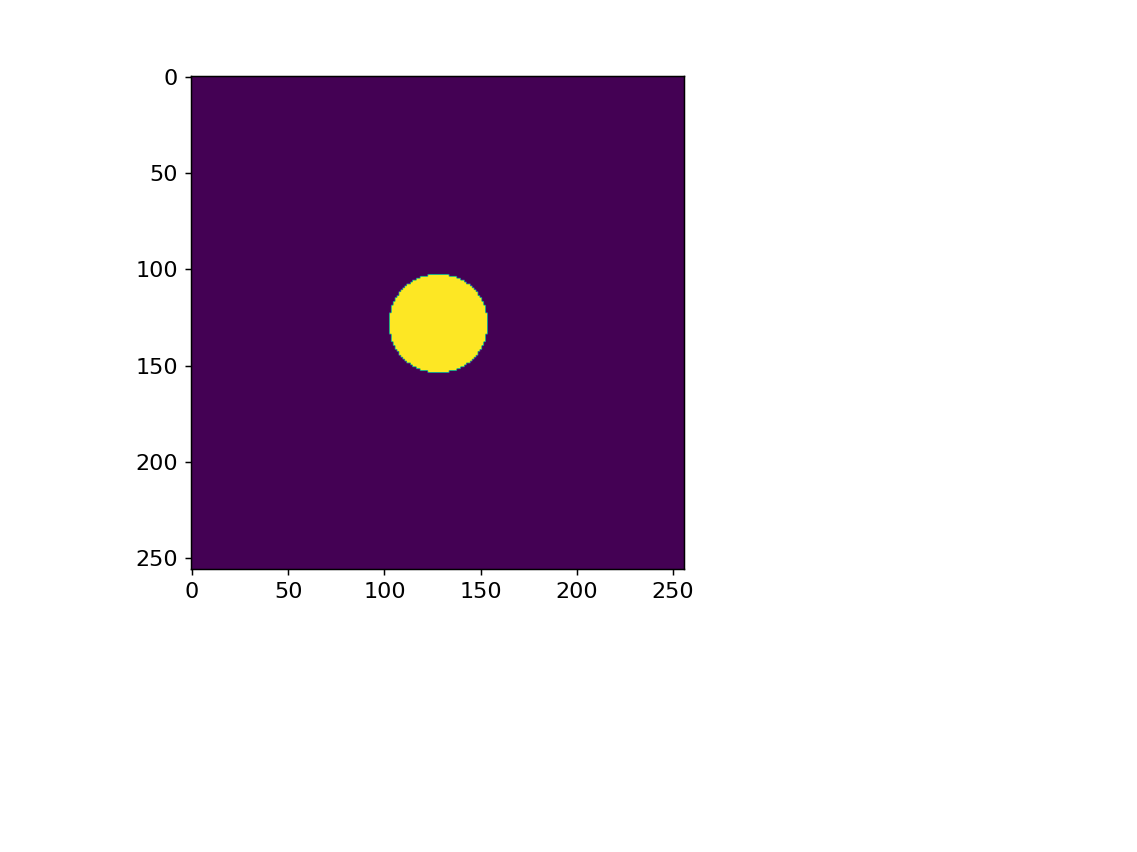

In [18]:
fig, ax = plt.subplots()
ax.imshow(sum_udf)

## Prepare parameters 

In [19]:
acc = float(par_dictionary['voltage'])# in kV
scan_real = float(par_dictionary['stepsize'])*1e-1 # in nm
semiconv=float(par_dictionary['aperture'])*1e3 # In mrad
rad = data_4D.aperture_radius

com = (data_4D.center_y,data_4D.center_x)
generate_order = 2**(np.arange(3,8))

In [20]:
complex_dtype = np.complex64

## Allocation

In [21]:
error_phase = []
error_all = []
error_amp = []

rec_livewdd = []
compressed_result = []
energy_result = []
std_result = []

In [22]:
for order in generate_order:
    ## Run Pre-Computed Wiener Filter
   
    scan_idx, wiener_filter_compressed,row_exp, col_exp,coeff = prepare_livewdd(ds.shape, acc, scan_real, 
                                                                            semiconv, rad, com, order,
                                                                            complex_dtype, 6.0)
    # Store Compressed
    compressed_result.append(compress(sum_udf, coeff))
    energy, std = calculate_energy_std(data_4D.data_4D, coeff, order, compress(sum_udf, coeff))
    energy_result.append(energy)
    std_result.append(std)
    # Run Live WDD
    live_wddudf = ctx.run_udf(dataset=ds, roi = None, 
                           udf= WDDUDF(wiener_filter_compressed, scan_idx, coeff, row_exp, col_exp, complex_dtype))
    live_wdd_recon = live_wddudf['reconstructed']
    
    # Store Phase Recon
    rec_livewdd.append(live_wdd_recon)
    
    ## Measure Error
    norm_wdd_pyptycho = wdd_pyptycho/np.linalg.norm(wdd_pyptycho)
    norm_live_wdd_recon = live_wdd_recon/np.linalg.norm(live_wdd_recon)
    error_all.append(np.linalg.norm(norm_wdd_pyptycho - norm_live_wdd_recon)**2/np.linalg.norm(norm_wdd_pyptycho)**2)
    error_amp.append(np.linalg.norm(np.abs(norm_wdd_pyptycho) - np.abs(norm_live_wdd_recon))**2/np.linalg.norm(norm_wdd_pyptycho)**2)
    error_phase.append(np.linalg.norm(np.angle(norm_wdd_pyptycho) - np.angle(norm_live_wdd_recon))**2/np.linalg.norm(np.angle(norm_wdd_pyptycho))**2)
    
    print('Error order ', order)

timer pre computing Wiener 7.00088s
Error order  8
timer pre computing Wiener 6.64751s
Error order  16
timer pre computing Wiener 7.57568s
Error order  32
timer pre computing Wiener 24.43970s
Error order  64
timer pre computing Wiener 22.10694s
Error order  128


In [23]:
error_all, error_amp, error_phase

([0.00011525380043668924,
  2.3193537769915627e-05,
  2.065063458725906e-05,
  2.1158202073159793e-05,
  2.1735863321724355e-05],
 [5.963535447670349e-07,
  1.8186590466100227e-07,
  1.4385556062039648e-07,
  1.413567553244026e-07,
  1.3832413361836618e-07],
 [0.1249171475809643,
  0.025066555765274997,
  0.022361980818834157,
  0.02292440975852767,
  0.023564767219032685])

<IPython.core.display.Javascript object>


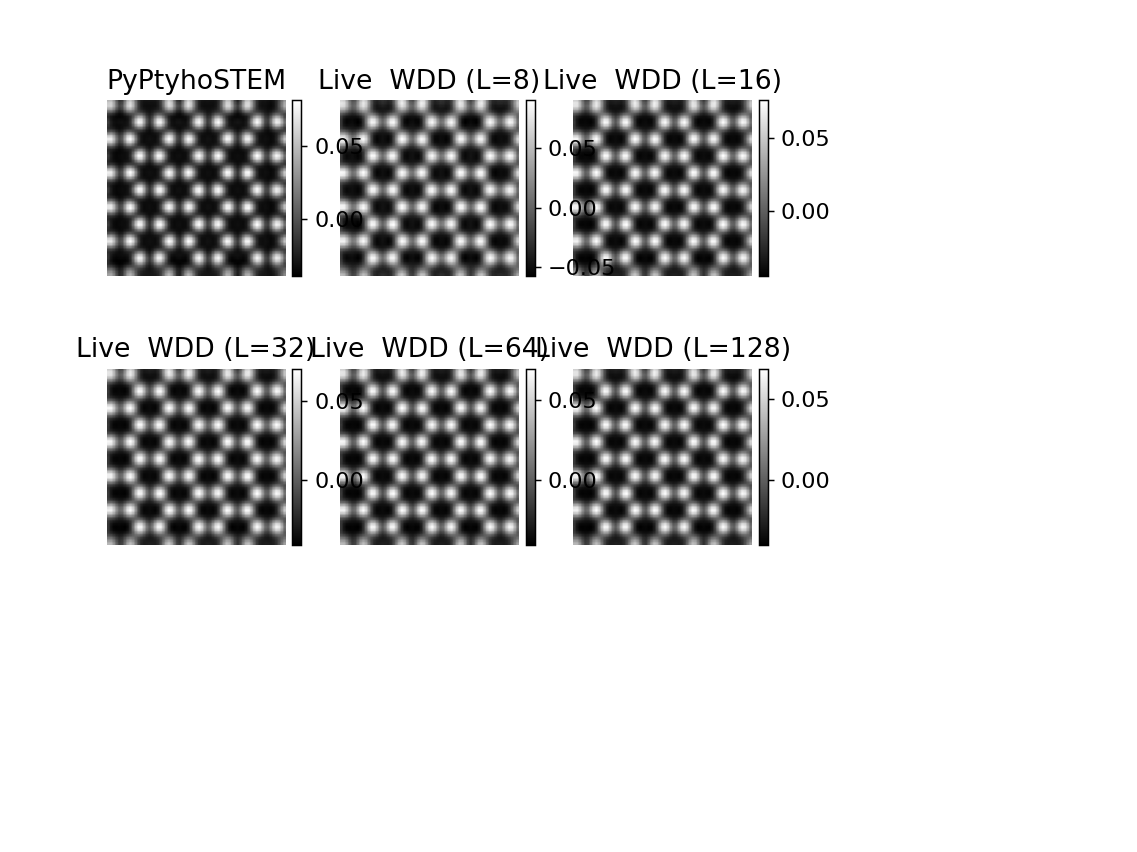

In [24]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,((ax1,ax2, ax3),
     (ax4,ax5, ax6)) = plt.subplots(2,3, sharex=True, sharey=True)
#fig.tight_layout()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax4)
cax4 = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax5)
cax5 = divider.append_axes('right', size='5%', pad=0.05)
divider = make_axes_locatable(ax6)
cax6 = divider.append_axes('right', size='5%', pad=0.05)

im1 = ax1.imshow(np.angle(wdd_pyptycho),cmap = 'gray')
im2 = ax2.imshow(np.angle(rec_livewdd[0]),cmap = 'gray')
im3 = ax3.imshow(np.angle(rec_livewdd[1]),cmap = 'gray')
im4 = ax4.imshow(np.angle(rec_livewdd[2]),cmap = 'gray')
im5 = ax5.imshow(np.angle(rec_livewdd[3]),cmap = 'gray')
im6 = ax6.imshow(np.angle(rec_livewdd[4]),cmap = 'gray')
ax1.set_axis_off()
ax1.set_title('PyPtyhoSTEM')
ax2.set_axis_off()
ax2.set_title('Live  WDD (L=8)')
ax3.set_axis_off()
ax3.set_title('Live  WDD (L=16)')
ax4.set_axis_off()
ax4.set_title('Live  WDD (L=32)')
ax5.set_axis_off()
ax5.set_title('Live  WDD (L=64)')
ax6.set_axis_off()
ax6.set_title('Live  WDD (L=128)')
fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')
fig.colorbar(im3, cax=cax3, orientation='vertical')
fig.colorbar(im4, cax=cax4, orientation='vertical')
fig.colorbar(im5, cax=cax5, orientation='vertical')
fig.colorbar(im6, cax=cax6, orientation='vertical')

In [25]:
#tikzplotlib.save('Phase_Rec_L.tex')

In [29]:
#tikzplotlib.save('Diff_L.tex')

<IPython.core.display.Javascript object>


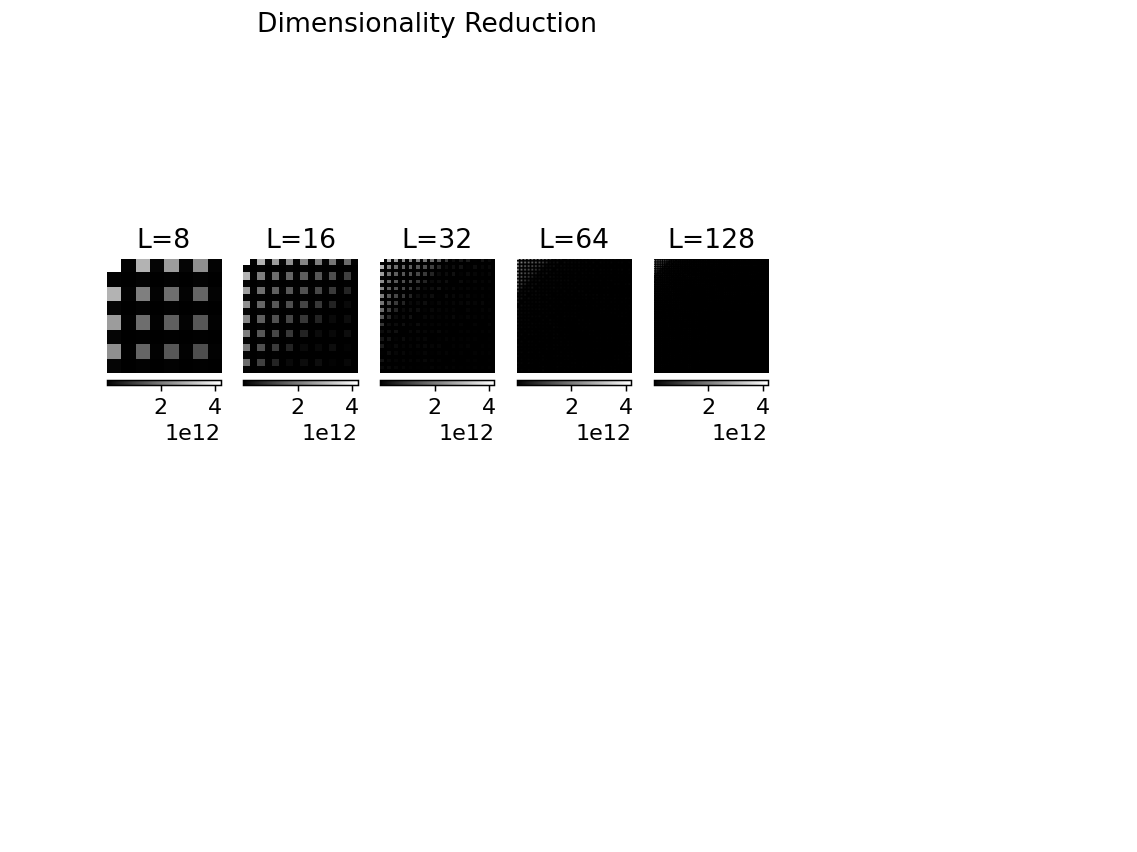

Text(0.5, 0.98, 'Dimensionality Reduction')

In [34]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,((ax1,ax2, ax3, ax4, ax5)) = plt.subplots(1,5)
#fig.tight_layout()
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax4)
cax4 = divider.append_axes('bottom', size='5%', pad=0.05)
divider = make_axes_locatable(ax5)
cax5 = divider.append_axes('bottom', size='5%', pad=0.05)
 

im1 = ax1.imshow(energy_result[0],cmap = 'gray')
im2 = ax2.imshow(energy_result[1],cmap = 'gray')
im3 = ax3.imshow(energy_result[2],cmap = 'gray')
im4 = ax4.imshow(energy_result[3],cmap = 'gray')
im5 = ax5.imshow(energy_result[4],cmap = 'gray')
 
ax1.set_axis_off()
ax1.set_title('L=8')
ax2.set_axis_off()
ax2.set_title('L=16')
ax3.set_axis_off()
ax3.set_title('L=32')
ax4.set_axis_off()
ax4.set_title('L=64')
ax5.set_axis_off()
ax5.set_title('L=128')

fig.colorbar(im1, cax=cax1, orientation='horizontal')
fig.colorbar(im2, cax=cax2, orientation='horizontal')
fig.colorbar(im3, cax=cax3, orientation='horizontal')
fig.colorbar(im4, cax=cax4, orientation='horizontal')
fig.colorbar(im5, cax=cax5, orientation='horizontal')
fig.suptitle('Dimensionality Reduction') 